# Differential Expression and Pathway analysis
The goal of this notebook is to take the processed feature counts and experimental design tables and use GSEA, ROntoTools, and QuaternaryProd to generate and compare pathway analyses. This notebook runs code in R using the DESeq2 differential expression package.

1. input full featureCount tables into DESeq2
2. ROntoTools
3. GSEA
4. QuaternaryProd with STRING database

## Preparation
1. install R packages (see R install document)


## Instructions
Before running this notebook, format the feature count data with the featureCountprocessing-generic notebook. The notebooks are separated because the processing notebook runs Python code, not R. Once the processed featureCounts and experimental design table have been created:

1. Run the first cell to import the necessary libraries and define the functions used to process the data.
2. 

In [17]:
#import libraries
library("DESeq2")

#define functions for DESeq2 object creation and heatmap creation
#based on Griffith Lab tutorial here: https://genviz.org/module-04-expression/0004/02/01/DifferentialExpression/

#input and process sample data (experiment design)
input_sample_data <- function(filepath, print_debug=FALSE){
    sampleData <- read.delim(filepath)
    #save copy of sampleData
    #sampleData_v2 <- sampleData
    
    rownames(sampleData) <- sampleData$SampleID.Lab
    #make data type = factor for Cell Line and Time Point (both otherwise treated as continuous variables since both are numbers)
    sampleData$Cell.Line <- factor(sampleData$Cell.Line)
    sampleData$Time.Point <- factor(sampleData$Time.Point)
    if(print_debug == TRUE){
        print(head(sampleData))
        }
    return(sampleData)
}

#Input and process raw gene counts (Feature Counts)
input_raw_counts <- function(filepath, sampleData, print_debug=FALSE){
    rawCounts <- read.delim(filepath)
    #print(head(rawCounts))
    
    geneID <- rawCounts$Geneid
    sampleIndex <- grepl("ES\\d+", colnames(rawCounts))
    rawCounts <- as.matrix(rawCounts[,sampleIndex])
    rownames(rawCounts) <- geneID
     if(print_debug == TRUE){
        print(head(rawCounts))
    }
    rawCounts <- rawCounts[,unique(rownames(sampleData))]
    if(print_debug == TRUE){
        print(head(rawCounts))
    }
    cat("Test that dimensions of rawCounts and sampleData match:", all(colnames(rawCounts) == rownames(sampleData)), "\n")
    return(rawCounts)
}


## Comparisons to make:
1. MRTX alone vs. MRTX + BI and vs MRTX + SHP2i at 6 and 72 hr (H358 only for SHP2i)
2. 0 vs. 6, 0 vs. 72 hr, and 6 hr vs. 72 hr within drug treatments
4. MRTX + BI vs MRTX + SHP2i at 6 and 72 hr (H358 only)
5. S2 KO vs S2 KO + MRTX
6. NT + MRTX + BI vs S2 KO + MRTX + BI

In [21]:
#H358 input rawCounts (featureCounts) and sample data (experimental design)
sampleData_H358 <- input_sample_data("20210209_experiment_design_H358.tsv")
rawCounts_H358 <- input_raw_counts("20210209_featureCount_H358.tsv", sampleData_H358)
#make DESeq2DataSet object, specifying CRISPR status as a blocking factor and Time point as the comparison variable
#choosing blocking factor and comparison variable is required, and if there are no divisions in the category chosen an error will occur "model matrix is not full rank"
dds_H358 <- DESeqDataSetFromMatrix(countData=rawCounts_H358, colData=sampleData_H358, design= ~ CRISPR + Time.Point)

Test that dimensions of rawCounts and sampleData match: TRUE 


In [60]:
sampleData_H358_72_MB <- input_sample_data("20210209_experiment_design_H358_72_MB.tsv")
rawCounts_H358_72_MB <- input_raw_counts("20210209_featureCount_H358.tsv", sampleData_H358_72_MB)
#make DESeq2DataSet object, specifying CRISPR status as a blocking factor and Time point as the comparison variable
#choosing blocking factor and comparison variable is required, and if there are no divisions in the category chosen an error will occur "model matrix is not full rank"
dds_H358_72_MB <- DESeqDataSetFromMatrix(countData=rawCounts_H358_72_MB, colData=sampleData_H358_72_MB, design= ~ Population + BI)

Test that dimensions of rawCounts and sampleData match: TRUE 


In [24]:
#View sampleData to understand its format/information when choosing variables later
head(sampleData_H358)

,X,SampleID.Lab,Cell.Line,Inhibition.Status,CRISPR,MRTX,BI,SHP2i,Time.Point,Population
,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
ES58NTXX01,0,ES58NTXX01,58,NTXX,NT,False,False,False,0,A
ES58NTXX02,1,ES58NTXX02,58,NTXX,NT,False,False,False,0,A
ES58NTXX03,2,ES58NTXX03,58,NTXX,NT,False,False,False,0,B
ES58NTXX04,3,ES58NTXX04,58,NTXX,NT,False,False,False,0,B
ES58S1XX01,4,ES58S1XX01,58,S1XX,S1,False,False,False,0,A
ES58S1XX02,5,ES58S1XX02,58,S1XX,S1,False,False,False,0,A


In [20]:
#filter for genes with at least 5 counts across all samples to reduce dimensions
##Make function
print(dim(dds_H358))
print(dim(dds_H358[rowSums(counts(dds_H358)) > 5, ]))
dds_H358 <- dds_H358[rowSums(counts(dds_H358)) > 5, ]

[1] 63677    59

[1] 34696    59

In [61]:
#filter for genes with at least 5 counts across all samples to reduce dimensions
print(dim(dds_H358_72_MB))
print(dim(dds_H358_72_MB[rowSums(counts(dds_H358_72_MB)) > 5, ]))
dds_H358_72_MB <- dds_H358_72_MB[rowSums(counts(dds_H358_72_MB)) > 5, ]

[1] 63677     8
[1] 27119     8


In [22]:
#load BiocParallel library and register number of cores to use (based on CPU) for parallel processing to increase speed
#if used set parallel = TRUE for DEseq() and results()
library(BiocParallel)
register(MulticoreParam(4))

In [52]:
#perform DESeq on dataset object to estimate size factors, dispersion, and find negative bionomial GLM fitting and Wald statistic
#Takes 5-10 minutes without parallel processing, 1-5 minutes with 4 cores
dds_H358_DESeq <- DESeq(dds_H358, parallel=TRUE)

estimating size factors

estimating dispersions

gene-wise dispersion estimates: 4 workers

mean-dispersion relationship

final dispersion estimates, fitting model and testing: 4 workers

-- replacing outliers and refitting for 4 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



In [57]:
dds_H358_results <- results(dds_H358_DESeq, contrast=c("Time.Point", "0", "72"))
summary(dds_H358_results)


out of 42301 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 6522, 15%
LFC < 0 (down)     : 7624, 18%
outliers [1]       : 2, 0.0047%
low counts [2]     : 15167, 36%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



## Quality control plots for whole dataset

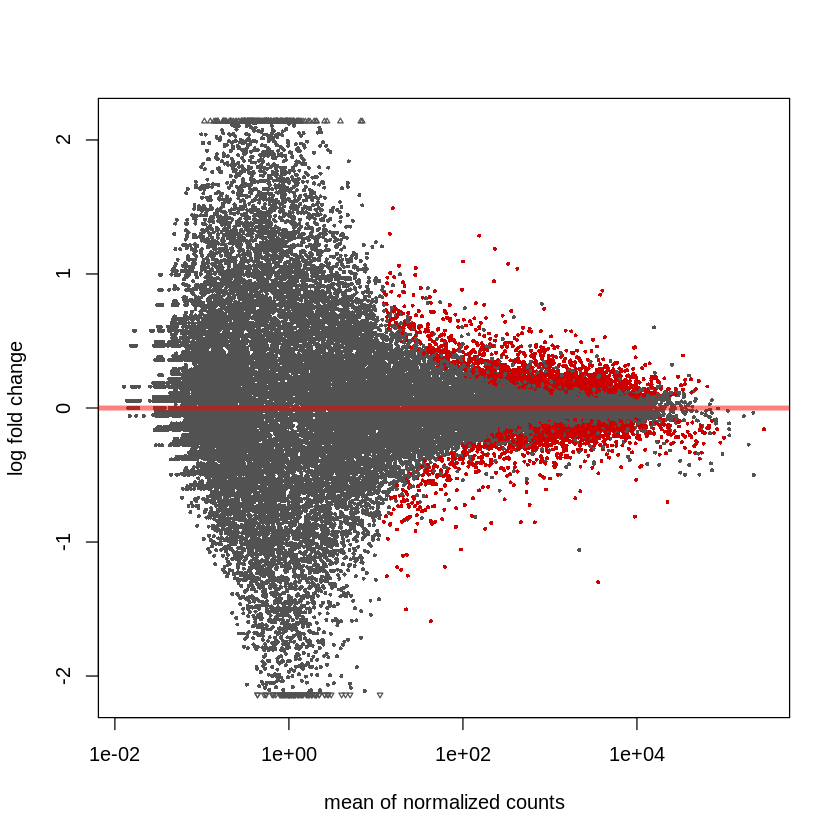

In [27]:
plotMA(dds_H358_results)


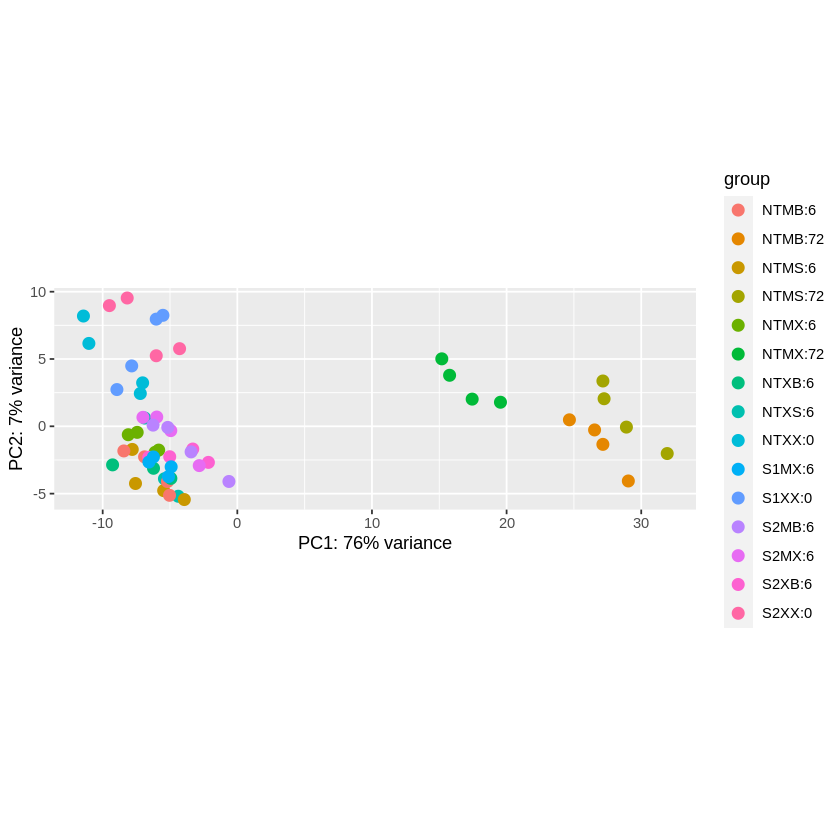

In [30]:
#PCA and sample distances
vsd <- vst(dds_H358_DESeq, blind=FALSE)
plotPCA(vsd, intgroup=c("Inhibition.Status", "Time.Point"))

In [34]:
plt <- plotPCA(vsd, intgroup=c("CRISPR", "Population"))

In [38]:
#print to file
png("Results/H358_PCA_cell_pop.png")
print(plt)
dev.off()

png 
  2

In [39]:
plt <- plotPCA(vsd, intgroup=c("Inhibition.Status", "Time.Point"))
png("Results/H358_PCA_inhib-timept.png")
print(plt)
dev.off()

png 
  2

In [ ]:
#save dds object as .RData
#from https://bioinformatics-core-shared-training.github.io/cruk-summer-school-2020/RNAseq/html/04_DE_analysis_with_DESeq2.html#finally-save-the-results-in-a-new-rdata-object
#Extract the default contrast - Lacate v Virgin
#resLvV <- results(ddsObj, alpha=0.05)
#save(resLvV, ddsObj, sampleinfo, file="results/DE.RData")


## Set up dataset subsets for comparisons

In [62]:
#only 72 hour MRTX vs MRTX + BI comparison
dds_H358_72_MB <- DESeq(dds_H358_72_MB, parallel=TRUE)

estimating size factors

estimating dispersions

gene-wise dispersion estimates: 4 workers

mean-dispersion relationship

final dispersion estimates, fitting model and testing: 4 workers



In [67]:
dds_H358_72_MB$Inhibition.Status <- relevel(dds_H358_72_MB$Inhibition.Status, ref = "NTMX")
dds_H358_72_MB$Inhibition.Status

[1] NTMX NTMX NTMX NTMX NTMB NTMB NTMB NTMB
Levels: NTMX NTMB

In [74]:
dds_H358_72_MB_results <- results(dds_H358_72_MB, name="BI_True_vs_False")
summary(dds_H358_72_MB_results)


out of 27119 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 1578, 5.8%
LFC < 0 (down)     : 1181, 4.4%
outliers [1]       : 0, 0%
low counts [2]     : 10516, 39%
(mean count < 14)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



# Implement Pathway Analysis: Format data

Both ROntoTools and QuaternaryProd require dataframes with log2FoldChange, p-value, adjusted p-value, and Entrez ID (NCBI) for each gene. Apart from Entrez ID, these values are output from DESeq2 in results(). The following section isolates the values needed and correlated the ENSEMBL gene ID provided by featureCount with the Entrez ID.

In [ ]:
##Needs logFC, p value, adjusted pvalue, and gene pathway assignment, ordered by p value, from DESeq2 results table
#print(dds_H358_72_MB_results)
top_H358_72_MB <- dds_H358_72_MB_results[c("log2FoldChange","pvalue","padj")]
#order by pvalue (ascending)
top_H358_72_MB <- top_H358_72_MB[order(top_H358_72_MB$pvalue),]
#names(my_data)[names(my_data) == "Sepal.Length"] <- "sepal_length"

In [197]:
#library("clipr")
#write_clip(rownames(top_H358_72_MB), allow_non_interactive = TRUE)
#rownames(top_H358_72_MB)
#####write to a text file with comma separation, paste into DAVID gene converter to get entrez IDs, paste into KEGG converter to get KEGG IDs?
#Use AnnotationDbi, code from https://www.biostars.org/p/441386/
library("AnnotationDbi")
#Use three different databases with entrez and ENSEMBL IDs correlated
library("org.Hs.eg.db") #Homo sapiens organism level database from AnnotationDbi
library("EnsDb.Hsapiens.v75") #ENSEMBL database version 75, used in AnnotationDbi
library("EnsDb.Hsapiens.v86") #ENSEMBL database version 86, used in Ensembldb package
#columns(org.Hs.eg.db) # returns list of available keytypes

#use row names (ENSEMBL IDs) as keys, return entrez ID as new column
top_H358_72_MB$entrez = mapIds(org.Hs.eg.db,
                    keys=row.names(top_H358_72_MB), #Column containing Ensembl gene ids
                    column="ENTREZID",
                    keytype="ENSEMBL",
                    multiVals="first")
top_H358_72_MB$entrez_Ens75 = mapIds(EnsDb.Hsapiens.v75,
                    keys=row.names(top_H358_72_MB), #Column containing Ensembl gene ids
                    column="ENTREZID",
                    keytype="GENEID",
                    multiVals="first")
top_H358_72_MB$entrez_Ens86 = mapIds(EnsDb.Hsapiens.v86,
                    keys=row.names(top_H358_72_MB), #Column containing Ensembl gene ids
                    column="ENTREZID",
                    keytype="GENEID",
                    multiVals="first")
#top_H358_72_MB

'select()' returned 1:many mapping between keys and columns

Warning message:
"Unable to map 9032 of 27119 requested IDs."
Warning message:
"Unable to map 9820 of 27119 requested IDs."


In [198]:
#Merge available entrez IDs from all three databases
#From https://stackoverflow.com/questions/14563531/combine-column-to-remove-nas
top_H358_72_MB$merge_entrez <- top_H358_72_MB$entrez
top_H358_72_MB$merge_entrez[!is.na(top_H358_72_MB$entrez_Ens75)] <- top_H358_72_MB$entrez_Ens75[!is.na(top_H358_72_MB$entrez_Ens75)]  # merge with top_H358_72_MB$entrez_Ens75
top_H358_72_MB$merge_entrez[!is.na(top_H358_72_MB$entrez_Ens86)] <- top_H358_72_MB$entrez_Ens86[!is.na(top_H358_72_MB$entrez_Ens86)]  # merge with top_H358_72_MB$entrez_Ens86
#top_H358_72_MB

In [204]:
#make dataframe with all rows without an entrez ID assigned
unassigned <- top_H358_72_MB[is.na(top_H358_72_MB$merge_entrez), ]

#remove rows without an entrez ID assigned from main dataframe
top_H358_72_MB <- top_H358_72_MB[!is.na(top_H358_72_MB$merge_entrez), ]

#keep data columns and merged entrez IDs only
top_H358_72_MB <- subset(top_H358_72_MB, select = c(log2FoldChange, pvalue, padj, merge_entrez))

The following cells contain code for alternative methods of correlating ENSEMBL IDs to Entrez IDs. These methods either did not work in the current version or did not contribute any new ID assignments. However, they may be useful in the future to assign IDs and allow more genes to be used in pathway analysis, where the packages often require Entrez IDs.

In [199]:
##check if entrez IDs for unassigned ENSEMBL IDs are available in the ensembldb package database (should use the same v85 database as above, so none expected)
##count = 0 as expected, proceed without genes missing entrezids, may be available in subsequent database updates

#library(EnsDb.Hsapiens.v86)
#edb <- EnsDb.Hsapiens.v86
##listTables(edb)

##make dataframe with ENSEMBL IDs (included by default with genes()) and entrez IDs
#entrez_ens <- genes(edb, columns = c("entrezid"), return.type = "DataFrame")

##make dataframe of all genes in ensembldb database with entrezids
#entrez_ens_wo_na <- entrez_ens[!is.na(entrez_ens$entrezid), ]
#unassigned_IDs <- rownames(unassigned)
#count = 0
#for (ID in unassigned_IDs) {
#    if(ID %in% entrez_ens_wo_na$gene_id) {
#        count = count+1
#        print(ID)
#    }
#}
#print(count)



In [200]:
###biomaRt not functional with R < 4.0
###Code may be useful for later projects
###See Bioconductor -> BiomaRt

#To get the pathway assignment, need the entrez ID for the gene

#library(biomaRt)
# Retrieve the ensembl info
#ensembl <- useDataset("hsapiens_gene_ensembl", mart = ensembl)
#ensembl <- useMart("ENSEMBL_MART_ENSEMBL", dataset = "hsapiens_gene_ensembl")
#
# Filter the ensembl ID
#ids <- getBMlist(attributes=c("kegg_enzyme", "clone_based_ensembl_gene", "entrezgene_id"), filters="clone_based_ensembl_gene", values = "ENSG00000138061", mart = ensembl)
#ids
#ids <- getBM(filters = "ensembl_gene_id", attributes = c("ensembl_gene_id", 'entrezgene_id', 'entrezgene_accession'), values = rownames(top_H358_72_MB), mart = ensembl)

In [201]:
#biomaRt parameters options lists
#filters <- listFilters(ensembl)
#attrib <- listAttributes(ensembl)
#print(attrib[grep("Ensembl", attrib$description), ])
#print(filters[grep("Ensembl", filters$description), ])

# Implement Pathway Analysis: ROntoTools with KEGG HSA (human KEGG pathways)

From https://www.bioconductor.org/packages/release/bioc/vignettes/ROntoTools/inst/doc/rontotools.pdf

In [ ]:
library(ROntoTools)

### Load, examine, and process human KEGG pathways

In [82]:
#Download and parse KEGG pathways
require(graph)
require(ROntoTools)
kpg <- keggPathwayGraphs("hsa", verbose = FALSE)

Loading required package: graph

Loading required package: ROntoTools

Loading required package: boot

Loading required package: KEGGREST

Loading required package: KEGGgraph


Attaching package: ‘KEGGgraph’


The following object is masked from ‘package:graphics’:

    plot


Loading required package: Rgraphviz

Loading required package: grid


Attaching package: ‘Rgraphviz’


The following objects are masked from ‘package:IRanges’:

    from, to


The following objects are masked from ‘package:S4Vectors’:

    from, to


Using cached pathway data. Database info:
pathway          KEGG Pathway Database
path             Release 73.0+/01-03, Jan 15
                 Kanehisa Laboratories
                 343,170 entries

Default parameters detected. Using pre-parsed data.



In [ ]:
#update cache and download latest KEGG pathways
#kpg <- keggPathwayGraphs("hsa", updateCache = TRUE, verbose = TRUE)

In [85]:
#Options to inspect the pathways, see ROntoTools vignette on Bioconductor for more
#head(names(kpg))
#kpg[["path:hsa04110"]]
#head(nodes(kpg[["path:hsa04110"]]))

#the parser extracted the type of interaction for each gene-gene interaction in anattribute called subtype
#head(edgeData(kpg[["path:hsa04110"]], attr = "subtype"))

$`hsa:1029|hsa:4193`
[1] "inhibition"

$`hsa:1029|hsa:1019`
[1] "inhibition"

$`hsa:1029|hsa:1021`
[1] "inhibition"

$`hsa:1029|hsa:595`
[1] "inhibition"

$`hsa:1029|hsa:894`
[1] "inhibition"

$`hsa:1029|hsa:896`
[1] "inhibition"

In [87]:
#Using this attribute the function setEdgeWeights sets the same weight for all the interactions of the same type
kpg <- setEdgeWeights(kpg, edgeTypeAttr = "subtype", 
                      edgeWeightByType = list(activation = 1, inhibition = -1, 
                                              expression = 1, repression = -1),
                      defaultWeight = 0)

In [88]:
#retrieve the title of the pathways and not just their ids with the function keggPathwayNames
kpn <- keggPathwayNames("hsa")
head(kpn)

Using cached pathway data. Database info:
pathway          KEGG Pathway Database
path             Release 73.0+/01-03, Jan 15
                 Kanehisa Laboratories
                 343,170 entries



path:hsa03008                       path:hsa03013 
"Ribosome biogenesis in eukaryotes"                     "RNA transport" 
                      path:hsa03015                       path:hsa03018 
        "mRNA surveillance pathway"                   "RNA degradation" 
                      path:hsa03320                       path:hsa03460 
           "PPAR signaling pathway"            "Fanconi anemia pathway"

## QuaternaryProd with STRING database
From https://bioconductor.org/packages/release/bioc/vignettes/QuaternaryProd/inst/doc/QuaternaryProdVignette.pdf

Data set needs:
1. entrez ID of gene
2. pvalue of gene
3. fold change of gene

## GSEA with GAGE/Pathview and KEGG pathways
From http://bioconductor.org/packages/release/bioc/vignettes/gage/inst/doc/RNA-seqWorkflow.pdf

In [143]:
library(gage)
ref.idx=5:8
samp.idx=1:4
data(kegg.gs)

In [144]:
kegg.gs

$`hsa00010 Glycolysis / Gluconeogenesis`
 [1] "10327"  "124"    "125"    "126"    "127"    "128"    "130"    "130589"
 [9] "131"    "160287" "1737"   "1738"   "2023"   "2026"   "2027"   "217"   
[17] "218"    "219"    "220"    "2203"   "221"    "222"    "223"    "224"   
[25] "226"    "229"    "230"    "2538"   "2597"   "26330"  "2645"   "2821"  
[33] "3098"   "3099"   "3101"   "3939"   "3945"   "3948"   "441531" "501"   
[41] "5105"   "5106"   "5160"   "5161"   "5162"   "5211"   "5213"   "5214"  
[49] "5223"   "5224"   "5230"   "5232"   "5236"   "5313"   "5315"   "55276" 
[57] "55902"  "57818"  "669"    "7167"   "80201"  "83440"  "84532"  "8789"  
[65] "92483" 

$`hsa00020 Citrate cycle (TCA cycle)`
 [1] "1431"  "1737"  "1738"  "1743"  "2271"  "3417"  "3418"  "3419"  "3420" 
[10] "3421"  "4190"  "4191"  "47"    "48"    "4967"  "50"    "5091"  "5105" 
[19] "5106"  "5160"  "5161"  "5162"  "55753" "6389"  "6390"  "6391"  "6392" 
[28] "8801"  "8802"  "8803" 

$`hsa00030 Pentose phosphate pathway`
 [1] "2203"   "221823" "226"    "229"    "22934"  "230"    "2539"   "25796" 
 [9] "2821"   "51071"  "5211"   "5213"   "5214"   "5226"   "5236"   "55276" 
[17] "5631"   "5634"   "6120"   "64080"  "6888"   "7086"   "729020" "8277"  
[25] "84076"  "8789"   "9563"  

$`hsa00040 Pentose and glucuronate interconversions`
 [1] "10720"  "10941"  "217"    "219"    "224"    "231"    "27294"  "2990"  
 [9] "51084"  "51181"  "54490"  "54575"  "54576"  "54577"  "54578"  "54579" 
[17] "54600"  "54657"  "54658"  "54659"  "574537" "6120"   "729020" "7358"  
[25] "7360"   "7363"   "7364"   "7365"   "7366"   "7367"   "79799"  "9942"  

$`hsa00051 Fructose and mannose metabolism`
 [1] "197258" "2203"   "226"    "229"    "230"    "231"    "2762"   "29085" 
 [9] "29925"  "29926"  "3098"   "3099"   "3101"   "3795"   "4351"   "5207"  
[17] "5208"   "5209"   "5210"   "5211"   "5213"   "5214"   "5372"   "5373"  
[25] "57016"  "57103"  "6652"   "7167"   "7264"   "80201"  "8776"   "8789"  
[33] "8790"   "8898"   "9107"   "9108"  

$`hsa00052 Galactose metabolism`
 [1] "231"   "2538"  "2548"  "2582"  "2584"  "2585"  "2592"  "2595"  "2645" 
[10] "2683"  "2717"  "2720"  "3098"  "3099"  "3101"  "3906"  "3938"  "5211" 
[19] "5213"  "5214"  "5236"  "55276" "57818" "7360"  "80201" "8704"  "8972" 

$`hsa00053 Ascorbate and aldarate metabolism`
 [1] "10720"  "10941"  "217"    "219"    "223"    "224"    "501"    "54490" 
 [9] "54575"  "54576"  "54577"  "54578"  "54579"  "54600"  "54657"  "54658" 
[17] "54659"  "55586"  "574537" "7358"   "7363"   "7364"   "7365"   "7366"  
[25] "7367"   "79799" 

$`hsa00061 Fatty acid biosynthesis`
[1] "2194"  "27349" "31"    "32"    "54995" "55301"

$`hsa00071 Fatty acid metabolism`
 [1] "10449"  "10455"  "124"    "125"    "126"    "126129" "127"    "128"   
 [9] "130"    "131"    "1374"   "1375"   "1376"   "1579"   "1632"   "1892"  
[17] "1962"   "217"    "2180"   "2181"   "2182"   "219"    "223"    "224"   
[25] "23305"  "2639"   "284541" "30"     "3030"   "3032"   "3033"   "33"    
[33] "34"     "35"     "36"     "37"     "38"     "39"     "501"    "51"    
[41] "51703"  "81616"  "8310"  

$`hsa00072 Synthesis and degradation of ketone bodies`
[1] "3155"  "3157"  "3158"  "38"    "39"    "5019"  "56898" "622"   "64064"

$`hsa00100 Steroid biosynthesis`
 [1] "1056"   "10682"  "10826"  "120227" "1594"   "1595"   "1717"   "1718"  
 [9] "2222"   "3988"   "4047"   "50814"  "51478"  "6307"   "6309"   "6646"  
[17] "6713"   "7108"   "8435"  

$`hsa00120 Primary bile acid biosynthesis`
 [1] "10858" "10998" "1109"  "1581"  "1582"  "1593"  "23600" "3295"  "51302"
[10] "570"   "6342"  "6718"  "80270" "8309"  "9023"  "9420" 

$`hsa00130 Ubiquinone and other terpenoid-quinone biosynthesis`
[1] "10229" "27235" "3242"  "51004" "51805" "6898"  "84274"

$`hsa00140 Steroid hormone biosynthesis`
 [1] "100510686" "10720"     "10941"     "1109"      "1312"      "1543"     
 [7] "1545"      "1551"      "1576"      "1577"      "1581"      "1583"     
[13] "1584